In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import pandas as pd

In [2]:
# Consts
INF=0
SUP=200

In [29]:
def load_directory(directory, file_prefix):
    runs = []
    for i in range(len(os.listdir(directory))):
        f = os.path.join(directory, file_prefix + str(i + 1) + ".csv")
        if os.path.isfile(f):
            file_data = np.genfromtxt(f, delimiter=",", skip_header=1)
            runs.append(file_data)
    return runs, np.concatenate([np.reshape(r, -1) for r in runs])

def plot_hist(runs, title):
    fig, axs = plt.subplots(1)
    for i, r in enumerate(runs):
        axs.hist(np.reshape(r[np.logical_and(r>INF, r<SUP)], -1), bins='auto', density=True)
    axs.set_title(title)
    axs.set_xlim((INF,SUP))
    
def ks_test(runs, more_runs=[]):
    ks_test = []
    p_values = []
    if len(more_runs) == 0: # Compare to itself
        for j, rj in enumerate(runs):
            other_runs = np.concatenate([np.reshape(runs[i], -1) for i in range(len(runs)) if i != j])
            ks_test.append(ks_2samp(np.reshape(other_runs, -1), np.reshape(rj, -1)).statistic)
            p_values.append(ks_2samp(np.reshape(other_runs, -1), np.reshape(rj, -1)).pvalue)
    else: # Compare to other
        n = 2
        for j, rj in enumerate(runs):
            rj = rj[len(rj)*(n-2)//3:]
            ks_test.append(ks_2samp(np.reshape(more_runs, -1), np.reshape(rj, -1)).statistic)
            p_values.append(ks_2samp(np.reshape(more_runs, -1), np.reshape(rj, -1)).pvalue)
#     print('ks stat', ks_test)
#     print('p value', p_values)
    df = pd.DataFrame(np.reshape([ks_test, p_values], (len(ks_test), 2)), columns=['ks stat', 'p value'])
    print(df)
    return ks_test

def plot_ks_test_results(norm_norm, norm_anomaly, anomaly_anomaly, title=''):
    plt.title(title)
    plt.hist(norm_norm, bins=20, density=True, alpha=0.5, label='normal vs normal')
    plt.hist(norm_anomaly, bins=20, density=True, alpha=0.5, label='anomaly vs normal')
    plt.hist(anomaly_anomaly, bins=20, density=True, alpha=0.5, label='anomaly vs anomaly')
    plt.legend()
    
def threshold_dist(norm_norm, threshold_percent=0.95):
    sorted_n_n = norm_norm.copy()
    sorted_n_n.sort(reverse=True)
    threshold_index = int(len(sorted_n_n) * threshold_percent)
    avg_dist = np.average(sorted_n_n[:threshold_index])
    print('Average distance:', avg_dist)
    return avg_dist

def detect_anomalies(norm_anomaly, threshold):
    count_anom = [1 for i in norm_anomaly if i >= avg_dist]
    print('Total anomalies detected:', sum(count_anom), ' accuracy:' + str(sum(count_anom)*100/len(norm_anomaly)) + '%')
    

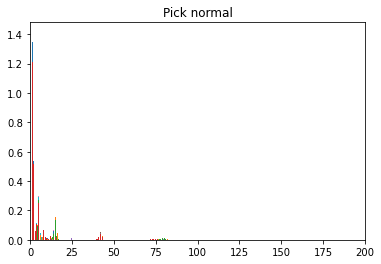

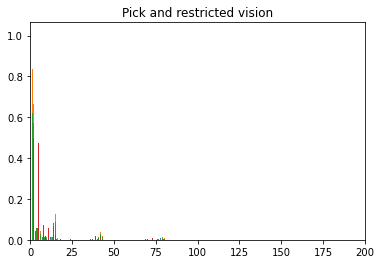

In [14]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and restricted vision'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/restricted_vision'
ANOM_FILE_PREFIX = 'counts_restricted_vision'

runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)



         ks stat       p value
0   7.147529e-02  2.234010e-02
1   5.723755e-02  5.532741e-02
2   2.517532e-02  2.156127e-02
3   1.804443e-02  3.147011e-02
4   1.360476e-02  1.350907e-02
5   3.418181e-02  4.074143e-02
6   1.360555e-02  4.729818e-02
7   1.898890e-33  3.221726e-04
8   5.300024e-20  6.060060e-21
9   3.135691e-03  5.363887e-05
10  5.289159e-04  1.540577e-07
11  2.189954e-01  4.785546e-02
12  1.862495e-10  3.478413e-16
13  1.114021e-01  4.080968e-19
         ks stat       p value
0   4.698432e-02  3.923597e-02
1   2.740328e-02  7.783574e-03
2   3.148499e-02  5.882856e-02
3   6.300382e-02  1.785802e-02
4   1.850813e-02  4.642815e-02
5   1.572784e-02  4.435198e-02
6   1.123629e-01  4.988039e-02
7   6.199065e-02  5.505876e-02
8   1.294512e-16  1.615575e-15
9   5.604484e-09  9.459101e-01
10  2.281677e-06  1.186034e-39
11  6.692448e-36  4.285977e-04
12  3.168565e-02  2.474205e-11
13  2.376471e-01  4.342558e-15
14  4.978087e-62  2.760572e-11
15  2.950816e-11  2.843259e-13
        

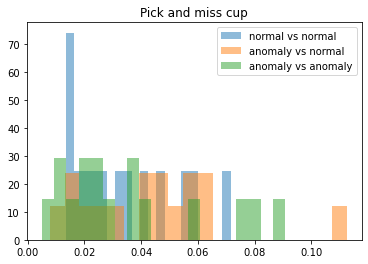

In [19]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Threshold range: ', 'Max dist:', max(ks_normal_normal), ' Min dist: ', min(ks_normal_normal))
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
count_anom = [1 for i in ks_normal_anomaly if i >= max(ks_normal_normal) or i <= min(ks_normal_normal)]
print('Total anomalies detected ', sum(count_anom), ' accuracy ' + str(sum(count_anom)*100/len(ks_normal_anomaly)) + '%')

In [16]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and miss cup'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/miss_cup'
ANOM_FILE_PREFIX = 'counts_miss_cup'

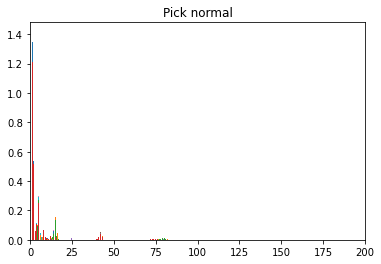

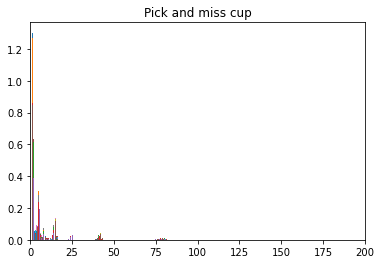

In [17]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

         ks stat       p value
0   7.147529e-02  2.234010e-02
1   5.723755e-02  5.532741e-02
2   2.517532e-02  2.156127e-02
3   1.804443e-02  3.147011e-02
4   1.360476e-02  1.350907e-02
5   3.418181e-02  4.074143e-02
6   1.360555e-02  4.729818e-02
7   1.898890e-33  3.221726e-04
8   5.300024e-20  6.060060e-21
9   3.135691e-03  5.363887e-05
10  5.289159e-04  1.540577e-07
11  2.189954e-01  4.785546e-02
12  1.862495e-10  3.478413e-16
13  1.114021e-01  4.080968e-19
         ks stat       p value
0   4.698432e-02  3.923597e-02
1   2.740328e-02  7.783574e-03
2   3.148499e-02  5.882856e-02
3   6.300382e-02  1.785802e-02
4   1.850813e-02  4.642815e-02
5   1.572784e-02  4.435198e-02
6   1.123629e-01  4.988039e-02
7   6.199065e-02  5.505876e-02
8   1.294512e-16  1.615575e-15
9   5.604484e-09  9.459101e-01
10  2.281677e-06  1.186034e-39
11  6.692448e-36  4.285977e-04
12  3.168565e-02  2.474205e-11
13  2.376471e-01  4.342558e-15
14  4.978087e-62  2.760572e-11
15  2.950816e-11  2.843259e-13
        

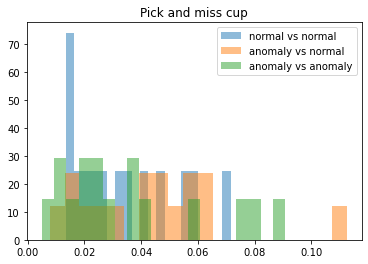

In [28]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
sorted_n_n = ks_normal_normal.copy()
sorted_n_n.sort(reverse=True)
threshold_index = int(np.floor(len(sorted_n_n) * 0.90))
print(np.average(sorted_n_n[:threshold_index]))
avg_dist = np.average(sorted_n_n[:threshold_index])
print('Threshold range: ', 'Max dist:', max(ks_normal_normal), ' Min dist: ', min(ks_normal_normal))
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
count_anom = [1 for i in ks_normal_anomaly if i >= avg_dist]
print('Total anomalies detected ', sum(count_anom), ' accuracy ' + str(sum(count_anom)*100/len(ks_normal_anomaly)) + '%')